**Primary Model - CNN**

The model chosen to accurately identify the type of a Pokémon from a given image will be a CNN. The encoder aspect of this model will contain several convolutional layers in which the Pokémon image input will be convolved with several kernels. Each kernel will contain the trainable weights that will be updated using gradient descent. Zero-padding and stride will be fine-tuned such that the model will provide the most accurate predictions. After each convolutional layer, a ReLU activation function will be used to map intermediate features and introduce non-linearity. The model will employ the use of max pooling between layers to downscale the image such that kernels in deeper layers look at the most important features of larger regions. In addition, the model will use dropout layers to randomly mask the outputs of some neurons to improve its ability to make more generalized predictions. For each iteration the weights will be trained through gradient descent using a cross entropy function which are commonly used in multi-label classification problems (ie. categorical cross entropy or binary cross entropy loss function). The classifier aspect will consist of the necessary amount of fully-connected layers and a final softmax layer to classify each Pokémon’s type(s).


**Loading Data**

In [3]:
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt

In [10]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


**Training Functions**

In [4]:
# Training
def get_model_name(name, batch_size, learning_rate, epoch):
    """ Generate a name for the model consisting of all the hyperparameter values

    Args:
        config: Configuration object containing the hyperparameters
    Returns:
        path: A string with the hyperparameter name and value concatenated
    """
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
    return path

In [5]:
class CNN(nn.Module): # test cnn to see if data is running properly
    def __init__(self):  # add dropout and softmax
        super(CNN, self).__init__()
        self.name = "CNN"
        self.conv1 = nn.Conv2d(3, 5, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(5, 10, 5)
        self.fc1 = nn.Linear(10 * 27 * 27, 32)
        self.fc2 = nn.Linear(32, 17)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 10 * 27 * 27)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = x.squeeze(1) # Flatten to [batch_size]
        return x

In [42]:
class PokemonTypeClassifier(nn.Module): # figure out multi label classification lol
    def __init__(self, typeClassifier): # use this to train lol jeslyn
        super(PokemonTypeClassifier, self).__init__()
        self.name = "PokemonTypeClassifier"
        if typeClassifier == 'Primary':
            numTypes = 18
        elif typeClassifier == 'Secondary':
            numTypes = 19
        self.conv1 = nn.Conv2d(3, 5, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(5, 10, 5)
        self.dropout = nn.Dropout(0.1)#dropout layer
        self.fc1 = nn.Linear(10 * 27 * 27, 32)
        self.fc2 = nn.Linear(32, numTypes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 10 * 27 * 27)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        x = x.squeeze(1) # Flatten to [batch_size]
        # didn't end up using softmax function bc criterion = crossEntropyLoss
        return x

**Training**

In [6]:
def get_accuracy(model, data, batch_size, train=False):

    correct = 0
    total = 0
    for imgs, labels in torch.utils.data.DataLoader(data, batch_size=batch_size):


        #############################################
        #To Enable GPU Usage
        if use_cuda and torch.cuda.is_available():
          imgs = imgs.cuda()
          labels = labels.cuda()
        #############################################


        output = model(imgs)

        #select index with maximum prediction score
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
    return correct / total

In [7]:
def train(net, train_data, val_data, batch_size=64, learning_rate=0.001, num_epochs=30):
    torch.manual_seed(1000)

    # Define the Loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
    #optimizer = optim.Adam(net.parameters(), lr=learning_rate)

    # load training and validation data
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)

    # Set up some arrays to store the training/test loss/erruracy
    iters, losses, train_acc, val_acc = [], [], [], []

    start_time = time.time()
    n = 0 # the number of iterations
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        total_train_loss = 0.0
        total_train_err = 0.0
        total_epoch = 0
        for imgs, labels in iter(train_loader):
            print("epoch: ", epoch, ", iter: ", n)
            #############################################
            #To Enable GPU Usage
            if use_cuda and torch.cuda.is_available():
              imgs = imgs.cuda()
              labels = labels.cuda()
            #############################################

            out = net(imgs)             # forward pass
            #labels_onehot = F.one_hot(labels, net.numTypes)
            loss = criterion(out, labels) # compute the total loss
            loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter
            optimizer.zero_grad()         # a clean up step for PyTorch

            # save the current training information

            iters.append(n)                                   # track the number of iterations during training
            losses.append(float(loss)/batch_size)             # compute *average* loss
            n += 1 # increment iters
            train_acc.append(get_accuracy(net, train_data, batch_size, train=True)) # compute training accuracy
            val_acc.append(get_accuracy(net, val_data, batch_size, train=False))  # compute validation accuracy

        print(("Epoch {}: Train acc: {} | Val acc: {}").format(
            epoch + 1,
            train_acc[-1],
            val_acc[-1]))

        # Save the current model (checkpoint) to a file
        #root_dir = 'd:\saved_models'
        model_path = get_model_name(net.name, batch_size, learning_rate, epoch)
        torch.save(net.state_dict(), model_path)

    end_time = time.time()
    total_time = end_time - start_time
    print("Training Completed\nTotal training time: {:.2f} seconds".format(total_time))

    # plotting
    plt.title("Training Curve")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(iters, train_acc, label="Train")
    plt.plot(iters, val_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()

    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))


# New Section

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [19]:
#for later
train_folder1 = '/content/gdrive/MyDrive/Third Year/Summer 2023/APS360/DATASETS/type1_datasets/train'
val_folder1 = '/content/gdrive/MyDrive/Third Year/Summer 2023/APS360/DATASETS/type1_datasets/val'
test_folder1 = '/content/gdrive/MyDrive/Third Year/Summer 2023/APS360/DATASETS/type1_datasets/test'

train_folder2 = '/content/gdrive/MyDrive/Third Year/Summer 2023/APS360/DATASETS/type2_datasets/train'
val_folder2 = '/content/gdrive/MyDrive/Third Year/Summer 2023/APS360/DATASETS/type2_datasets/val'
test_folder2 = '/content/gdrive/MyDrive/Third Year/Summer 2023/APS360/DATASETS/type2_datasets/val'

preprocess = transforms.Compose([
    transforms.Resize((120, 120)),
    transforms.ToTensor()  # Convert image to tensor without normalization
])

train_data1 = torchvision.datasets.ImageFolder(train_folder1, transform=preprocess)
val_data1 = torchvision.datasets.ImageFolder(val_folder1, transform=preprocess)
test_data1 = torchvision.datasets.ImageFolder(test_folder1, transform=preprocess)

train_data2 = torchvision.datasets.ImageFolder(train_folder2, transform=preprocess)
val_data2 = torchvision.datasets.ImageFolder(val_folder2, transform=preprocess)
test_data2 = torchvision.datasets.ImageFolder(test_folder2, transform=preprocess)

In [ ]:
print("total images: ", len(train_data1) + len(val_data1) + len(test_data1))

total images:  9885


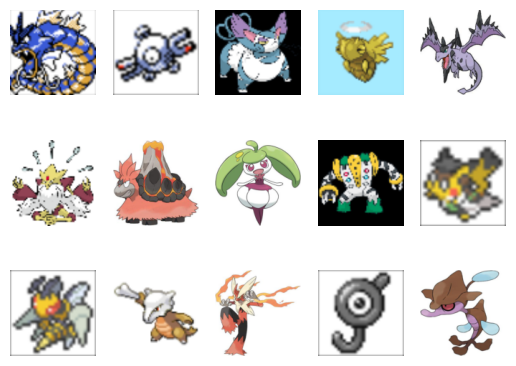

In [ ]:
data_loader = torch.utils.data.DataLoader(test_data1, batch_size=16, shuffle=True)
#plot some images from the training dataset
k = 0
for images, labels in data_loader:
    image = images[0]
    # place the colour channel at the end, instead of at the beginning
    img = np.transpose(image, [1,2,0])
    # normalize pixel intensity values to [0, 1]
    #img = img / 2 + 0.5
    plt.subplot(3, 5, k+1)
    plt.axis('off')
    plt.imshow(img)

    k += 1
    if k > 14:
        break

In [7]:
class PokemonTypeClassifier2(nn.Module): # figure out multi label classification lol
    def __init__(self, typeClassifier):
        super(PokemonTypeClassifier2, self).__init__()
        if typeClassifier == 'Primary':
            numTypes = 18
        elif typeClassifier == 'Secondary':
            numTypes = 19
        self.name = "PokemonTypeClassifier2"
        self.numTypes = numTypes

        self.conv1 = nn.Conv2d(3, 64, 8)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(64, 128, 8)
        self.conv3 = nn.Conv2d(128, 256, 8)
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(256 * 8 * 8, 512)
        self.fc2 = nn.Linear(512, numTypes)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 256 * 8 * 8)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        #x = self.softmax(x)
        x = x.squeeze(1) # Flatten to [batch_size]
        # didn't end up using softmax function bc criterion = crossEntropyLoss
        return x

In [ ]:
use_cuda = True

model = PokemonTypeClassifier2('Primary')

if use_cuda and torch.cuda.is_available():
  model.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')

CUDA is available!  Training on GPU ...


In [13]:
use_cuda = True

model = PokemonTypeClassifier2('Primary')

if use_cuda and torch.cuda.is_available():
  model.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')


preprocess = transforms.Compose([
    transforms.Resize((120, 120)),
    transforms.ToTensor()  # Convert image to tensor without normalization
])

#train(model, train_data1, val_data1, batch_size = 512, learning_rate = 0.1, num_epochs=10)
small_folder1 =  'C:\\Users\\Jeslyn\\Downloads\\small-20230721T151010Z-001\\small'
small_data1 = torchvision.datasets.ImageFolder(small_folder1, transform=preprocess)

train(model, small_data1, small_data1, batch_size = 10, learning_rate = 0.0075, num_epochs=20)

CUDA is not available.  Training on CPU ...
Epoch 1: Train acc: 0.1111111111111111 | Val acc: 0.1388888888888889


RuntimeError: Parent directory d: does not exist.

Epoch 1: Train acc: 0.10199556541019955 | Val acc: 0.11148086522462562
Epoch 2: Train acc: 0.13414634146341464 | Val acc: 0.1447587354409318
Epoch 3: Train acc: 0.14745011086474502 | Val acc: 0.1447587354409318
Epoch 4: Train acc: 0.14634146341463414 | Val acc: 0.1480865224625624
Epoch 5: Train acc: 0.12305986696230599 | Val acc: 0.12146422628951747
Epoch 6: Train acc: 0.12084257206208426 | Val acc: 0.1064891846921797
Epoch 7: Train acc: 0.1286031042128603 | Val acc: 0.15307820299500832
Epoch 8: Train acc: 0.13747228381374724 | Val acc: 0.129783693843594
Epoch 9: Train acc: 0.13303769401330376 | Val acc: 0.12312811980033278
Epoch 10: Train acc: 0.14634146341463414 | Val acc: 0.1497504159733777
Epoch 11: Train acc: 0.13747228381374724 | Val acc: 0.1480865224625624
Epoch 12: Train acc: 0.13414634146341464 | Val acc: 0.13311148086522462
Epoch 13: Train acc: 0.13636363636363635 | Val acc: 0.1497504159733777
Epoch 14: Train acc: 0.13747228381374724 | Val acc: 0.1464226289517471
Epoch 15: Tr

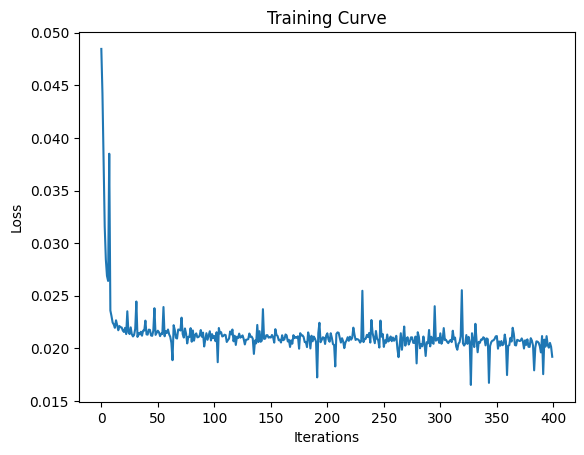

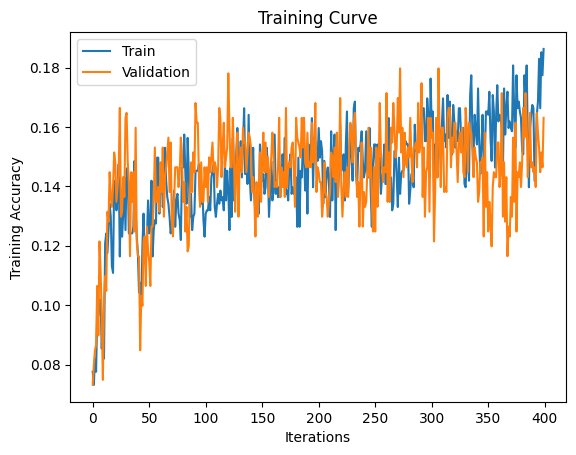

Final Training Accuracy: 0.18625277161862527
Final Validation Accuracy: 0.16306156405990016


In [ ]:
from torch.utils.data import random_split

# Calculate the number of samples to select for the validation set
validation_size = int(0.4 * len(val_data1))  # 20% of the dataset

# Randomly split the dataset into train and validation sets
train_dataset, validation_dataset = random_split(val_data1, [len(val_data1) - validation_size, validation_size])

# Get the paths of the selected validation images
validation_paths = [val_data1.samples[i][0] for i in validation_dataset.indices]

# You can also get the labels of the validation images if needed
validation_labels = [val_data1.samples[i][1] for i in validation_dataset.indices]

train(model, train_dataset, validation_dataset, batch_size = 128, learning_rate = 0.001, num_epochs=50)

In [ ]:
from torch.utils.data import random_split

# Calculate the number of samples to select for the validation set
validation_size = int(0.4 * len(val_data1))  # 20% of the dataset

# Randomly split the dataset into train and validation sets
train_dataset, validation_dataset = random_split(val_data1, [len(val_data1) - validation_size, validation_size])

# Get the paths of the selected validation images
validation_paths = [val_data1.samples[i][0] for i in validation_dataset.indices]

# You can also get the labels of the validation images if needed
validation_labels = [val_data1.samples[i][1] for i in validation_dataset.indices]



In [ ]:
use_cuda = True

model2 = PokemonTypeClassifier2('Primary')

if use_cuda and torch.cuda.is_available():
  model2.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')

train(model2, val_data1, test_data1, batch_size = 64, learning_rate = 0.001, num_epochs=100)

CUDA is available!  Training on GPU ...
Epoch 1: Train acc: 0.15169660678642716 | Val acc: 0.14342105263157895
Epoch 2: Train acc: 0.16101131071190952 | Val acc: 0.1361842105263158
Epoch 3: Train acc: 0.13972055888223553 | Val acc: 0.14407894736842106
Epoch 4: Train acc: 0.15103127079174983 | Val acc: 0.14671052631578949
Epoch 5: Train acc: 0.15834996673320026 | Val acc: 0.16052631578947368
Epoch 6: Train acc: 0.15635395874916833 | Val acc: 0.14144736842105263
Epoch 7: Train acc: 0.1483699268130406 | Val acc: 0.15
Epoch 8: Train acc: 0.1536926147704591 | Val acc: 0.15328947368421053
Epoch 9: Train acc: 0.1536926147704591 | Val acc: 0.1506578947368421
Epoch 10: Train acc: 0.16966067864271456 | Val acc: 0.15789473684210525
Epoch 11: Train acc: 0.16367265469061876 | Val acc: 0.15855263157894736
Epoch 12: Train acc: 0.17964071856287425 | Val acc: 0.1769736842105263
Epoch 13: Train acc: 0.18429807052561545 | Val acc: 0.15723684210526315
Epoch 14: Train acc: 0.1709913506320692 | Val acc: 0.1

FileNotFoundError: ignored

In [ ]:
model2 = PokemonTypeClassifier2('Primary')

if use_cuda and torch.cuda.is_available():
  model2.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')

train(model2, val_data1, test_data1, batch_size = 128, learning_rate = 0.001, num_epochs=100)

CUDA is available!  Training on GPU ...
Epoch 1: Train acc: 0.1317365269461078 | Val acc: 0.13421052631578947
Epoch 2: Train acc: 0.1437125748502994 | Val acc: 0.14144736842105263
Epoch 3: Train acc: 0.1490352628077179 | Val acc: 0.14407894736842106
Epoch 4: Train acc: 0.1483699268130406 | Val acc: 0.14210526315789473
Epoch 5: Train acc: 0.13439787092481703 | Val acc: 0.13092105263157894
Epoch 6: Train acc: 0.1377245508982036 | Val acc: 0.14210526315789473
Epoch 7: Train acc: 0.1483699268130406 | Val acc: 0.14671052631578949
Epoch 8: Train acc: 0.15834996673320026 | Val acc: 0.14868421052631578
Epoch 9: Train acc: 0.14437791084497673 | Val acc: 0.13026315789473683
Epoch 10: Train acc: 0.1490352628077179 | Val acc: 0.14407894736842106
Epoch 11: Train acc: 0.15568862275449102 | Val acc: 0.14342105263157895
Epoch 12: Train acc: 0.14637391882900866 | Val acc: 0.14407894736842106
Epoch 13: Train acc: 0.14770459081836326 | Val acc: 0.14276315789473684
Epoch 14: Train acc: 0.1550232867598137 

OSError: ignored

CUDA is available!  Training on GPU ...
Epoch 1: Train acc: 0.14238190286094476 | Val acc: 0.1355263157894737
Epoch 2: Train acc: 0.14770459081836326 | Val acc: 0.13815789473684212
Epoch 3: Train acc: 0.15236194278110446 | Val acc: 0.1361842105263158
Epoch 4: Train acc: 0.14703925482368596 | Val acc: 0.1388157894736842
Epoch 5: Train acc: 0.15103127079174983 | Val acc: 0.14342105263157895
Epoch 6: Train acc: 0.15036593479707253 | Val acc: 0.1361842105263158
Epoch 7: Train acc: 0.1490352628077179 | Val acc: 0.1401315789473684
Epoch 8: Train acc: 0.1550232867598137 | Val acc: 0.15
Epoch 9: Train acc: 0.14637391882900866 | Val acc: 0.1394736842105263
Epoch 10: Train acc: 0.15768463073852296 | Val acc: 0.1631578947368421
Epoch 11: Train acc: 0.17564870259481039 | Val acc: 0.16710526315789473
Epoch 12: Train acc: 0.18562874251497005 | Val acc: 0.19210526315789472
Epoch 13: Train acc: 0.16699933466400532 | Val acc: 0.15789473684210525
Epoch 14: Train acc: 0.21357285429141717 | Val acc: 0.206

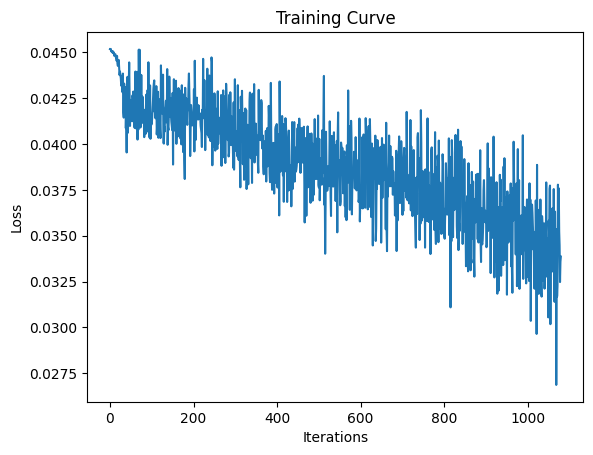

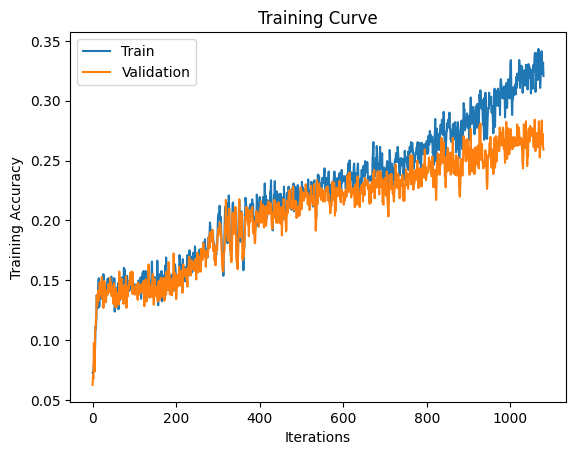

Final Training Accuracy: 0.3206919494344644
Final Validation Accuracy: 0.25921052631578945


In [ ]:
use_cuda = True

model2 = PokemonTypeClassifier2('Primary')

if use_cuda and torch.cuda.is_available():
  model2.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')

train(model2, val_data1, test_data1, batch_size = 64, learning_rate = 0.001, num_epochs=45)

In [ ]:
from google.colab import drive

# Save the model weights
save_path = get_model_name(model2.name, 64, 0.001, 44)  # Replace with the desired filename
torch.save(model2.state_dict(), save_path + '.h5')



NameError: ignored

In [45]:
import tensorflow as tf
from tensorflow.keras.models import save_model


In [ ]:
torch.save(model2.state_dict(), '/content/' + save_path +'.h5')


NameError: ignored

In [ ]:
model = PokemonTypeClassifier2('Primary')
model_path = '/content/gdrive/MyDrive/Third Year/Summer 2023/APS360 (1)/model_PokemonTypeClassifier2_bs64_lr0.001_epoch44'  # Update with your model's path
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [ ]:
use_cuda = True

if use_cuda and torch.cuda.is_available():
  model.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')

train(model, val_data1, test_data1, batch_size = 64, learning_rate = 0.001, num_epochs=45)

CUDA is available!  Training on GPU ...


KeyboardInterrupt: ignored

In [ ]:
class PokemonTypeClassifier2(nn.Module):
    def init(self, typeClassifier):
        super(PokemonTypeClassifier2, self).init()
        self.name = "PokemonTypeClassifier2"
        if typeClassifier == 'Primary':
            numTypes = 18
        elif typeClassifier == 'Secondary':
            numTypes = 19

        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(32, 64, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3),
            nn.ReLU(inplace=True),

            nn.Conv2d(128, 256, kernel_size=3),
            nn.ReLU(inplace=True),
        )

        self.classifier = nn.Sequential(
            nn.Linear(256 * 24 * 24, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.1),

            nn.Linear(512, numTypes)
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [ ]:
use_cuda = True

model = PokemonTypeClassifier2('Primary')

if use_cuda and torch.cuda.is_available():
  model.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')


preprocess = transforms.Compose([
    transforms.ToTensor()  # Convert image to tensor without normalization
])

small_folder1 =  '/content/gdrive/MyDrive/Third Year/Summer 2023/APS360/DATASETS/type1_datasets/small'
small_data1 = torchvision.datasets.ImageFolder(small_folder1, transform=preprocess)
print(len(small_data1))
#train(model, small_data1, small_data1 num_epochs=75)

CUDA is available!  Training on GPU ...
36


TESTING PROGRESS REPORT MODEL ON NEW DATA

In [11]:
pip install tensorflow==2.12.*

                                              0.0/276.6 MB ? eta -:--:--
                                             0.5/276.6 MB 16.5 MB/s eta 0:00:17
                                             1.7/276.6 MB 21.8 MB/s eta 0:00:13
                                             3.2/276.6 MB 25.5 MB/s eta 0:00:11
                                             4.6/276.6 MB 26.4 MB/s eta 0:00:11
                                             6.0/276.6 MB 27.4 MB/s eta 0:00:10
     -                                       7.3/276.6 MB 27.4 MB/s eta 0:00:10
     -                                       8.7/276.6 MB 27.8 MB/s eta 0:00:10
     -                                      10.2/276.6 MB 28.3 MB/s eta 0:00:10
     -                                      11.7/276.6 MB 31.2 MB/s eta 0:00:09
     -                                      13.0/276.6 MB 29.7 MB/s eta 0:00:09
     --                                     14.6/276.6 MB 31.2 MB/s eta 0:00:09
     --                                     15.


[notice] A new release of pip is available: 23.1.2 -> 23.2
[notice] To update, run: python.exe -m pip install --upgrade pip


ERROR: Could not install packages due to an OSError: [WinError 32] The process cannot access the file because it is being used by another process: 'c:\\Users\\Jeslyn\\AppData\\Local\\Programs\\Python\\Python311\\Lib\\site-packages\\wrapt\\decorators.py'
Consider using the `--user` option or check the permissions.


[notice] A new release of pip is available: 23.1.2 -> 23.2
[notice] To update, run: python.exe -m pip install --upgrade pip



  Using cached tensorflow-2.12.1-cp311-cp311-win_amd64.whl (1.9 kB)
                                              0.0/272.9 MB ? eta -:--:--
                                              0.4/272.9 MB 9.2 MB/s eta 0:00:30
                                             1.6/272.9 MB 17.4 MB/s eta 0:00:16
                                             3.1/272.9 MB 21.8 MB/s eta 0:00:13
                                             4.4/272.9 MB 23.3 MB/s eta 0:00:12
                                             5.6/272.9 MB 25.3 MB/s eta 0:00:11
                                             6.7/272.9 MB 23.9 MB/s eta 0:00:12
     -                                       7.7/272.9 MB 25.8 MB/s eta 0:00:11
     -                                       9.3/272.9 MB 25.9 MB/s eta 0:00:11
     -                                      10.4/272.9 MB 27.3 MB/s eta 0:00:10
     -                                      11.6/272.9 MB 27.3 MB/s eta 0:00:10
     -                                      12.5/272.9 MB 

In [5]:
#import required libraries
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import tensorflow as tf
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

import time

In [6]:
import torchvision.models
alexnet = torchvision.models.alexnet(pretrained=True)
! pip install wget

c:\Users\Jeslyn\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Jeslyn\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



[notice] A new release of pip is available: 23.1.2 -> 23.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [59]:
class AlexNet(nn.Module):
    def __init__(self, typeClassifier):
        super(AlexNet, self).__init__()
        self.name = "AlexNet"
        if typeClassifier == 'Primary':
            numTypes = 18
        elif typeClassifier == 'Secondary':
            numTypes = 19

        self.conv1 = nn.Conv2d(256, 380, kernel_size=2) #in_channels, out_chanels, kernel_size
        self.conv2 = nn.Conv2d(380, 512, kernel_size=2) #in_channels, out_chanels, kernel_size
        self.fc1 = nn.Linear(512*4*4, 1024)
        self.fc2 = nn.Linear(1024, numTypes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(-1, 512*4*4)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [8]:
model = AlexNet('Primary')
model_path = '/content/gdrive/MyDrive/Third Year/Summer 2023/APS360/PROGRESS REPORT/Saving Models/model_AlexNet_bs80_lr0.005_epoch9'  # Update with your model's path
model.load_state_dict(torch.load(model_path))

FileNotFoundError: [Errno 2] No such file or directory: '/content/gdrive/MyDrive/Third Year/Summer 2023/APS360/PROGRESS REPORT/Saving Models/model_AlexNet_bs80_lr0.005_epoch9'

In [51]:
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()  # Convert image to tensor without normalization
])

img_path = '/content/jello_shots.jpg'


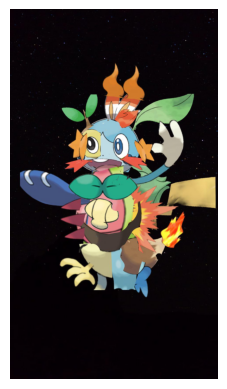

In [52]:
from PIL import Image
import requests
from io import BytesIO

# Replace 'your_image_url' with the actual URL of the image you want to open
image_url = 'https://i.redd.it/6hehqowldu661.jpg'
# Download the image from the URL
response = requests.get(image_url)
response.raise_for_status()  # Check for any download errors

# Open the image using PIL.Image.open()
image = Image.open(BytesIO(response.content))
tensor_input = preprocess(image)

plt.imshow(image)
plt.axis('off')  # Remove axis ticks and labels
plt.show()
# Now you can work with the 'image' object, e.g., display, manipulate, or save the image.


<class 'torch.Tensor'>


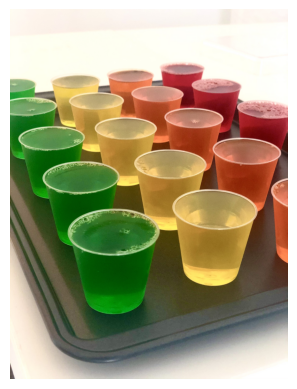

In [ ]:
img = Image.open(img_path)
tensor_input = preprocess(img)
print(type(tensor_input))

plt.imshow(img)
plt.axis('off')  # Remove axis ticks and labels
plt.show()
# Now you can work with the 'image' object, e.g., display, manipulate, or save the image.

In [53]:
feature_extraction = alexnet.features(tensor_input)
features_tensor = torch.from_numpy(feature_extraction.detach().numpy())

In [54]:
output = model(features_tensor)
pred = tf.nn.softmax(output.detach().numpy())
max_index = tf.argmax(pred, axis=1)
print(pred[0])
print(max_index.numpy().item())
classes = ['Bug', 'Dark', 'Dragon', 'Electric', 'Fairy', 'Fighting',
             'Fire', 'Flying', 'Ghost', 'Grass', 'Ground', 'Ice',
             'Normal', 'Poison', 'Psychic', 'Rock', 'Steel', 'Water', 'None']
print(classes[max_index.numpy().item()])

tf.Tensor(
[0.12843217 0.05270987 0.03205359 0.04293977 0.03735119 0.08004262
 0.17374755 0.0118463  0.05213463 0.10102753 0.03344962 0.01724003
 0.0793222  0.03352356 0.02315692 0.03074304 0.01487579 0.05540349], shape=(18,), dtype=float32)
6
Fire


In [18]:
path_train = 'D:\AlexNet Type1 Balanced Features-20230721T150532Z-001\AlexNet Type1 Balanced Features\Train'
path_val = 'D:\AlexNet Type1 Balanced Features-20230721T150532Z-001\AlexNet Type1 Balanced Features\Val'
path_test = 'D:\AlexNet Type1 Balanced Features-20230721T150532Z-001\AlexNet Type1 Balanced Features\Test'

train_dataset_new = torchvision.datasets.DatasetFolder(path_train, loader=torch.load, extensions=('.tensor'))
valid_dataset_new = torchvision.datasets.DatasetFolder(path_val, loader=torch.load, extensions=('.tensor'))
test_dataset_new = torchvision.datasets.DatasetFolder(path_test, loader=torch.load, extensions=('.tensor'))


In [35]:
use_cuda = True
model = AlexNet('Primary')
if use_cuda and torch.cuda.is_available():
  model.cuda()
  print('CUDA is available!  Training on GPU ...')
  train(model, train_dataset_new, train_dataset_new, batch_size=512, learning_rate = 0.005, num_epochs=10)
else:
  print('CUDA is not available.  Training on CPU ...')

CUDA is available!  Training on GPU ...
epoch:  0 , iter:  0
epoch:  0 , iter:  1
epoch:  0 , iter:  2
epoch:  0 , iter:  3
epoch:  0 , iter:  4
epoch:  0 , iter:  5
epoch:  0 , iter:  6
epoch:  0 , iter:  7
epoch:  0 , iter:  8
epoch:  0 , iter:  9
epoch:  0 , iter:  10
Epoch 1: Train acc: 0.09306569343065693 | Val acc: 0.09306569343065693
epoch:  1 , iter:  11
epoch:  1 , iter:  12
epoch:  1 , iter:  13
epoch:  1 , iter:  14
epoch:  1 , iter:  15
epoch:  1 , iter:  16
epoch:  1 , iter:  17
epoch:  1 , iter:  18
epoch:  1 , iter:  19
epoch:  1 , iter:  20
epoch:  1 , iter:  21
Epoch 2: Train acc: 0.10364963503649635 | Val acc: 0.10364963503649635
epoch:  2 , iter:  22
epoch:  2 , iter:  23
epoch:  2 , iter:  24
epoch:  2 , iter:  25
epoch:  2 , iter:  26
epoch:  2 , iter:  27
epoch:  2 , iter:  28
epoch:  2 , iter:  29
epoch:  2 , iter:  30
epoch:  2 , iter:  31
epoch:  2 , iter:  32
Epoch 3: Train acc: 0.12664233576642336 | Val acc: 0.12664233576642336
epoch:  3 , iter:  33
epoch:  3

KeyboardInterrupt: ignored

In [37]:
use_cuda = True
model = AlexNet('Primary')
if use_cuda and torch.cuda.is_available():
  model.cuda()
  print('CUDA is available!  Training on GPU ...')
  train(model, train_dataset_new, train_dataset_new, batch_size=512, learning_rate = 0.005, num_epochs=10)
else:
  print('CUDA is not available.  Training on CPU ...')

CUDA is available!  Training on GPU ...
epoch:  0 , iter:  0
epoch:  0 , iter:  1
epoch:  0 , iter:  2
epoch:  0 , iter:  3
epoch:  0 , iter:  4
epoch:  0 , iter:  5
epoch:  0 , iter:  6
epoch:  0 , iter:  7
epoch:  0 , iter:  8
epoch:  0 , iter:  9
epoch:  0 , iter:  10
epoch:  0 , iter:  11
epoch:  0 , iter:  12
epoch:  0 , iter:  13
epoch:  0 , iter:  14
epoch:  0 , iter:  15
epoch:  0 , iter:  16
epoch:  0 , iter:  17
epoch:  0 , iter:  18
epoch:  0 , iter:  19
epoch:  0 , iter:  20
epoch:  0 , iter:  21
epoch:  0 , iter:  22
epoch:  0 , iter:  23
epoch:  0 , iter:  24
epoch:  0 , iter:  25
epoch:  0 , iter:  26
Epoch 1: Train acc: 0.11120834244877124 | Val acc: 0.11120834244877124
epoch:  1 , iter:  27
epoch:  1 , iter:  28
epoch:  1 , iter:  29
epoch:  1 , iter:  30
epoch:  1 , iter:  31
epoch:  1 , iter:  32
epoch:  1 , iter:  33
epoch:  1 , iter:  34
epoch:  1 , iter:  35
epoch:  1 , iter:  36
epoch:  1 , iter:  37
epoch:  1 , iter:  38
epoch:  1 , iter:  39
epoch:  1 , iter:  

OSError: ignored

In [9]:
model = AlexNet('Primary')
model_path = 'D:\AlexNet Type1 Balanced Features-20230721T150532Z-001\model_AlexNet_bs512_lr0.005_epoch8'  # Update with your model's path
model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))

<All keys matched successfully>

In [34]:
use_cuda = True

if use_cuda and torch.cuda.is_available():
  model.cuda()
  print('CUDA is available!  Training on GPU ...')
  train(model, train_dataset_new, valid_dataset_new, batch_size=512, learning_rate = 0.005, num_epochs=10)
else:
  print('CUDA is not available.  Training on CPU ...')
  train(model, train_dataset_new, valid_dataset_new, batch_size=512, learning_rate = 0.005, num_epochs=10)

CUDA is not available.  Training on CPU ...


KeyboardInterrupt: 

In [14]:
use_cuda = True

if use_cuda and torch.cuda.is_available():
  model.cuda()
  print('CUDA is available!  Training on GPU ...')
  train(model, train_dataset_new, valid_dataset_new, batch_size=512, learning_rate = 0.005, num_epochs=10)
else:
  print('CUDA is not available.  Training on CPU ...')
  train(model, train_dataset_new, valid_dataset_new, batch_size=512, learning_rate = 0.005, num_epochs=10)

CUDA is not available.  Training on CPU ...


KeyboardInterrupt: 

Smaller Batch Size

CUDA is not available.  Training on CPU ...
epoch:  0 , iter:  0
epoch:  0 , iter:  1
epoch:  0 , iter:  2
epoch:  0 , iter:  3
epoch:  0 , iter:  4
epoch:  0 , iter:  5
epoch:  0 , iter:  6
epoch:  0 , iter:  7
epoch:  0 , iter:  8
epoch:  0 , iter:  9
epoch:  0 , iter:  10
epoch:  0 , iter:  11
epoch:  0 , iter:  12
epoch:  0 , iter:  13
epoch:  0 , iter:  14
epoch:  0 , iter:  15
epoch:  0 , iter:  16
epoch:  0 , iter:  17
epoch:  0 , iter:  18
epoch:  0 , iter:  19
epoch:  0 , iter:  20
epoch:  0 , iter:  21
epoch:  0 , iter:  22
epoch:  0 , iter:  23
epoch:  0 , iter:  24
epoch:  0 , iter:  25
epoch:  0 , iter:  26
epoch:  0 , iter:  27
epoch:  0 , iter:  28
epoch:  0 , iter:  29
epoch:  0 , iter:  30
epoch:  0 , iter:  31
epoch:  0 , iter:  32
epoch:  0 , iter:  33
epoch:  0 , iter:  34
epoch:  0 , iter:  35
epoch:  0 , iter:  36
epoch:  0 , iter:  37
epoch:  0 , iter:  38
epoch:  0 , iter:  39
epoch:  0 , iter:  40
epoch:  0 , iter:  41
epoch:  0 , iter:  42
epoch:  0 , iter:  4

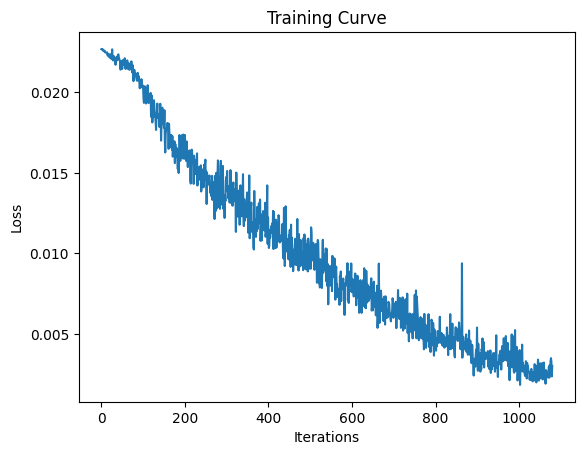

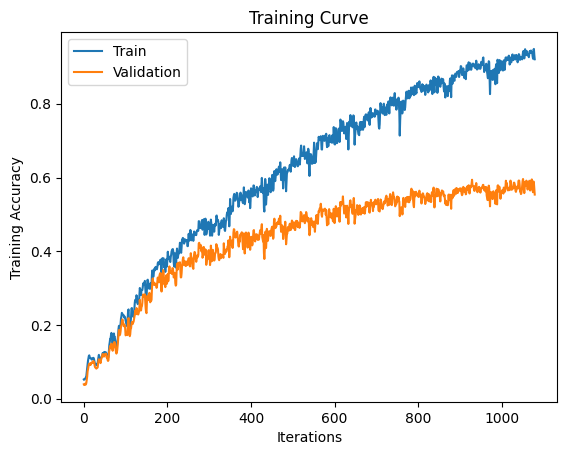

Final Training Accuracy: 0.9207321519725807
Final Validation Accuracy: 0.5537848605577689


In [15]:
use_cuda = True

model = AlexNet('Primary')

if use_cuda and torch.cuda.is_available():
  model.cuda()
  print('CUDA is available!  Training on GPU ...')
  train(model, train_dataset_new, valid_dataset_new, batch_size=128, learning_rate = 0.005, num_epochs=10)
else:
  print('CUDA is not available.  Training on CPU ...')
  train(model, train_dataset_new, valid_dataset_new, batch_size=128, learning_rate = 0.005, num_epochs=10)

In [20]:
import torch.nn.functional as F

class AlexNet2(nn.Module):
    def __init__(self, typeClassifier):
        super(AlexNet2, self).__init__()
        self.name = "AlexNet2"
        if typeClassifier == 'Primary':
            numTypes = 18
        elif typeClassifier == 'Secondary':
            numTypes = 19

        self.conv1 = nn.Conv2d(256, 380, kernel_size=3, padding=1) # in_channels, out_channels, kernel_size
        self.conv2 = nn.Conv2d(380, 512, kernel_size=3, padding=1) # in_channels, out_channels, kernel_size
        self.fc1 = nn.Linear(512 * 6 * 6, 1024)
        self.fc2 = nn.Linear(1024, numTypes)
        self.dropout = nn.Dropout(0.5)  # Add dropout for regularization

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(-1, 512 * 6 * 6)  # Correct the reshaping to match the size of the last convolutional layer
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


CUDA is not available.  Training on CPU ...
epoch:  0 , iter:  0
epoch:  0 , iter:  1
epoch:  0 , iter:  2
epoch:  0 , iter:  3
epoch:  0 , iter:  4
epoch:  0 , iter:  5
epoch:  0 , iter:  6
epoch:  0 , iter:  7
epoch:  0 , iter:  8
epoch:  0 , iter:  9
epoch:  0 , iter:  10
epoch:  0 , iter:  11
epoch:  0 , iter:  12
epoch:  0 , iter:  13
epoch:  0 , iter:  14
epoch:  0 , iter:  15
epoch:  0 , iter:  16
epoch:  0 , iter:  17
epoch:  0 , iter:  18
epoch:  0 , iter:  19
epoch:  0 , iter:  20
epoch:  0 , iter:  21
epoch:  0 , iter:  22
epoch:  0 , iter:  23
epoch:  0 , iter:  24
epoch:  0 , iter:  25
epoch:  0 , iter:  26
epoch:  0 , iter:  27
epoch:  0 , iter:  28
epoch:  0 , iter:  29
epoch:  0 , iter:  30
epoch:  0 , iter:  31
epoch:  0 , iter:  32
epoch:  0 , iter:  33
epoch:  0 , iter:  34
epoch:  0 , iter:  35
epoch:  0 , iter:  36
epoch:  0 , iter:  37
epoch:  0 , iter:  38
epoch:  0 , iter:  39
epoch:  0 , iter:  40
epoch:  0 , iter:  41
epoch:  0 , iter:  42
epoch:  0 , iter:  4

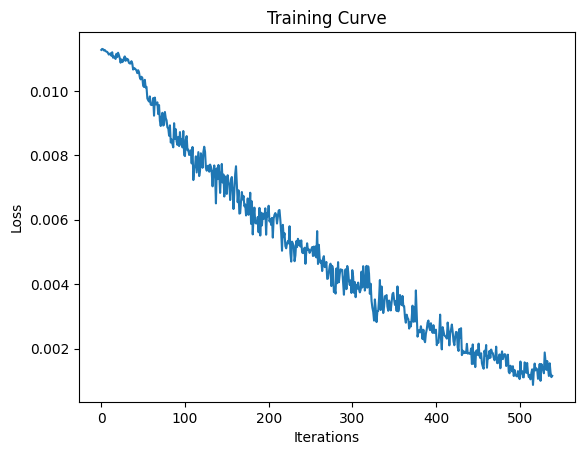

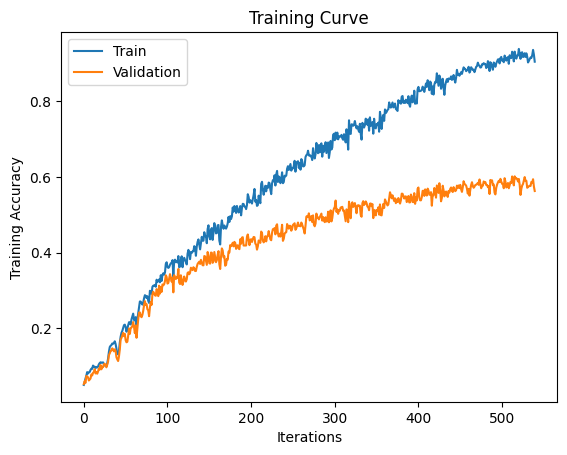

Final Training Accuracy: 0.9046889812586597
Final Validation Accuracy: 0.5627490039840638


In [25]:
use_cuda = True

model = AlexNet2('Primary')

if use_cuda and torch.cuda.is_available():
  model.cuda()
  print('CUDA is available!  Training on GPU ...')
  train(model, train_dataset_new, valid_dataset_new, batch_size=256, learning_rate = 0.01, num_epochs=10)
else:
  print('CUDA is not available.  Training on CPU ...')
  train(model, train_dataset_new, valid_dataset_new, batch_size=256, learning_rate = 0.01, num_epochs=10)

In [11]:
import torch.nn.functional as F

class AlexNet3(nn.Module):
    def __init__(self, typeClassifier):
        super(AlexNet3, self).__init__()
        self.name = "AlexNet3"
        if typeClassifier == 'Primary':
            numTypes = 18
        elif typeClassifier == 'Secondary':
            numTypes = 19

        self.conv1 = nn.Conv2d(256, 380, kernel_size=3, padding=1) # in_channels, out_channels, kernel_size
        self.conv2 = nn.Conv2d(380, 512, kernel_size=3, padding=1) # in_channels, out_channels, kernel_size
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(512 * 3 * 3, 1024)
        self.fc2 = nn.Linear(1024, numTypes)
        self.dropout = nn.Dropout(0.5)  # Add dropout for regularization

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = x.view(-1, 512 * 3 * 3)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


In [29]:
use_cuda = True

model = AlexNet2('Primary')

if use_cuda and torch.cuda.is_available():
  model.cuda()
  print('CUDA is available!  Training on GPU ...')
  train(model, train_dataset_new, valid_dataset_new, batch_size=256, learning_rate = 0.01, num_epochs=10)
else:
  print('CUDA is not available.  Training on CPU ...')
  train(model, train_dataset_new, valid_dataset_new, batch_size=256, learning_rate = 0.01, num_epochs=10)

CUDA is not available.  Training on CPU ...
epoch:  0 , iter:  0


KeyboardInterrupt: 

In [30]:
model = AlexNet2('Primary')
model_path = 'D:\AlexNet Type1 Balanced Features-20230721T150532Z-001\model_AlexNet2_bs256_lr0.01_epoch9'  # Update with your model's path
model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))

<All keys matched successfully>

In [32]:
use_cuda = True

if use_cuda and torch.cuda.is_available():
  model.cuda()
  print('CUDA is available!  Training on GPU ...')
  train(model, train_dataset_new, valid_dataset_new, batch_size=256, learning_rate = 0.0025, num_epochs=10)
else:
  print('CUDA is not available.  Training on CPU ...')
  train(model, train_dataset_new, valid_dataset_new, batch_size=256, learning_rate = 0.0025, num_epochs=10)

CUDA is not available.  Training on CPU ...
epoch:  0 , iter:  0
epoch:  0 , iter:  1
epoch:  0 , iter:  2
epoch:  0 , iter:  3
epoch:  0 , iter:  4
epoch:  0 , iter:  5
epoch:  0 , iter:  6
epoch:  0 , iter:  7
epoch:  0 , iter:  8
epoch:  0 , iter:  9
epoch:  0 , iter:  10
epoch:  0 , iter:  11
epoch:  0 , iter:  12
epoch:  0 , iter:  13
epoch:  0 , iter:  14
epoch:  0 , iter:  15
epoch:  0 , iter:  16
epoch:  0 , iter:  17
epoch:  0 , iter:  18
epoch:  0 , iter:  19
epoch:  0 , iter:  20
epoch:  0 , iter:  21
epoch:  0 , iter:  22
epoch:  0 , iter:  23
epoch:  0 , iter:  24
epoch:  0 , iter:  25
epoch:  0 , iter:  26
epoch:  0 , iter:  27
epoch:  0 , iter:  28
epoch:  0 , iter:  29
epoch:  0 , iter:  30
epoch:  0 , iter:  31
epoch:  0 , iter:  32
epoch:  0 , iter:  33
epoch:  0 , iter:  34
epoch:  0 , iter:  35
epoch:  0 , iter:  36
epoch:  0 , iter:  37
epoch:  0 , iter:  38
epoch:  0 , iter:  39
epoch:  0 , iter:  40
epoch:  0 , iter:  41
epoch:  0 , iter:  42
epoch:  0 , iter:  4

KeyboardInterrupt: 

CUDA is not available.  Training on CPU ...
epoch:  0 , iter:  0
epoch:  0 , iter:  1
epoch:  0 , iter:  2
epoch:  0 , iter:  3
epoch:  0 , iter:  4
epoch:  0 , iter:  5
epoch:  0 , iter:  6
epoch:  0 , iter:  7
epoch:  0 , iter:  8
epoch:  0 , iter:  9
epoch:  0 , iter:  10
epoch:  0 , iter:  11
epoch:  0 , iter:  12
epoch:  0 , iter:  13
epoch:  0 , iter:  14
epoch:  0 , iter:  15
epoch:  0 , iter:  16
epoch:  0 , iter:  17
epoch:  0 , iter:  18
epoch:  0 , iter:  19
epoch:  0 , iter:  20
epoch:  0 , iter:  21
epoch:  0 , iter:  22
epoch:  0 , iter:  23
epoch:  0 , iter:  24
epoch:  0 , iter:  25
epoch:  0 , iter:  26
epoch:  0 , iter:  27
epoch:  0 , iter:  28
epoch:  0 , iter:  29
epoch:  0 , iter:  30
epoch:  0 , iter:  31
epoch:  0 , iter:  32
epoch:  0 , iter:  33
epoch:  0 , iter:  34
epoch:  0 , iter:  35
epoch:  0 , iter:  36
epoch:  0 , iter:  37
epoch:  0 , iter:  38
epoch:  0 , iter:  39
epoch:  0 , iter:  40
epoch:  0 , iter:  41
epoch:  0 , iter:  42
epoch:  0 , iter:  4

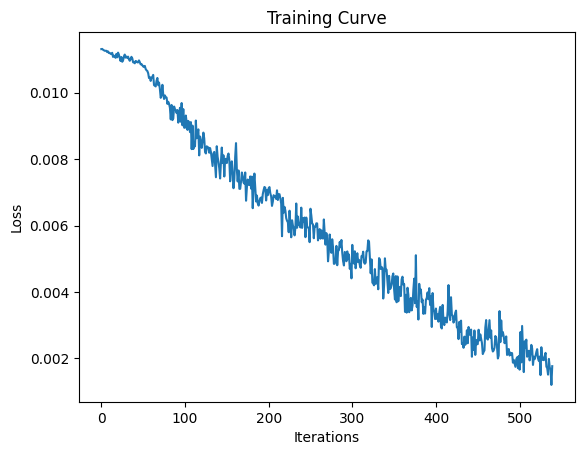

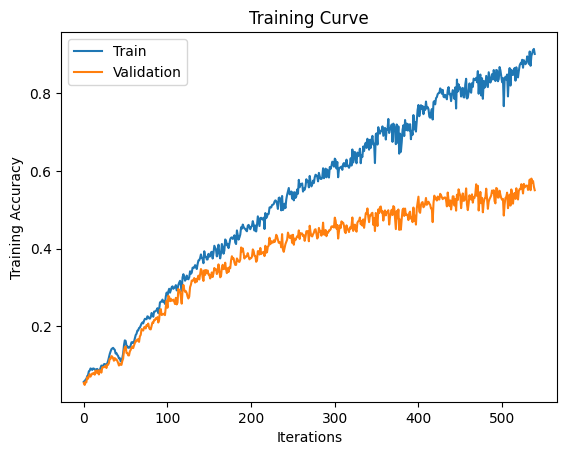

Final Training Accuracy: 0.9003135710639539
Final Validation Accuracy: 0.550132802124834


In [12]:
use_cuda = True

model = AlexNet3('Primary')

if use_cuda and torch.cuda.is_available():
  model.cuda()
  print('CUDA is available!  Training on GPU ...')
  train(model, train_dataset_new, valid_dataset_new, batch_size=256, learning_rate = 0.01, num_epochs=10)
else:
  print('CUDA is not available.  Training on CPU ...')
  train(model, train_dataset_new, valid_dataset_new, batch_size=256, learning_rate = 0.01, num_epochs=10)

In [16]:
model = AlexNet3('Primary')
model_path = 'D:\AlexNet Type1 Balanced Features-20230721T150532Z-001\model_AlexNet3_bs256_lr0.01_epoch9'  # Update with your model's path
model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))

<All keys matched successfully>

CUDA is not available.  Training on CPU ...
epoch:  0 , iter:  0
epoch:  0 , iter:  1
epoch:  0 , iter:  2
epoch:  0 , iter:  3
epoch:  0 , iter:  4
epoch:  0 , iter:  5
epoch:  0 , iter:  6
epoch:  0 , iter:  7
epoch:  0 , iter:  8
epoch:  0 , iter:  9
epoch:  0 , iter:  10
epoch:  0 , iter:  11
epoch:  0 , iter:  12
epoch:  0 , iter:  13
epoch:  0 , iter:  14
epoch:  0 , iter:  15
epoch:  0 , iter:  16
epoch:  0 , iter:  17
epoch:  0 , iter:  18
epoch:  0 , iter:  19
epoch:  0 , iter:  20
epoch:  0 , iter:  21
epoch:  0 , iter:  22
epoch:  0 , iter:  23
epoch:  0 , iter:  24
epoch:  0 , iter:  25
epoch:  0 , iter:  26
epoch:  0 , iter:  27
epoch:  0 , iter:  28
epoch:  0 , iter:  29
epoch:  0 , iter:  30
epoch:  0 , iter:  31
epoch:  0 , iter:  32
epoch:  0 , iter:  33
epoch:  0 , iter:  34
epoch:  0 , iter:  35
epoch:  0 , iter:  36
epoch:  0 , iter:  37
epoch:  0 , iter:  38
epoch:  0 , iter:  39
epoch:  0 , iter:  40
epoch:  0 , iter:  41
epoch:  0 , iter:  42
epoch:  0 , iter:  4

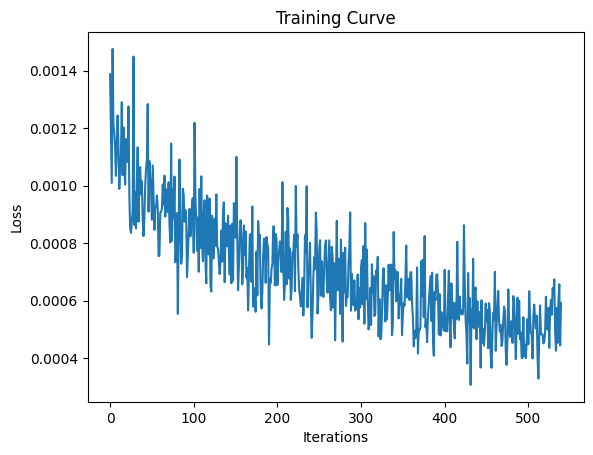

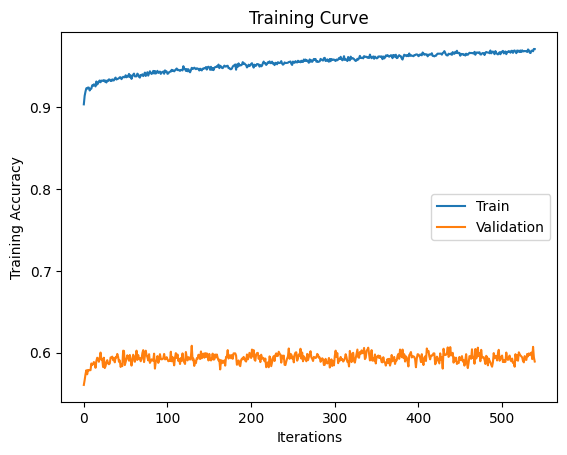

Final Training Accuracy: 0.9708305987019616
Final Validation Accuracy: 0.5893094289508632


In [17]:
use_cuda = True

if use_cuda and torch.cuda.is_available():
  model.cuda()
  print('CUDA is available!  Training on GPU ...')
  train(model, train_dataset_new, valid_dataset_new, batch_size=256, learning_rate = 0.001, num_epochs=10)
else:
  print('CUDA is not available.  Training on CPU ...')
  train(model, train_dataset_new, valid_dataset_new, batch_size=256, learning_rate = 0.001, num_epochs=10)

In [31]:
model = AlexNet2('Primary')
model_path = 'D:\AlexNet Type1 Balanced Features-20230721T150532Z-001\model_AlexNet2_bs256_lr0.0025_epoch2'  # Update with your model's path
model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))

<All keys matched successfully>

In [32]:
get_accuracy(model, test_dataset_new, 256, train = False)

0.5900900900900901

In [36]:
import torch.nn.functional as F

class AlexNet4(nn.Module):
    def __init__(self, typeClassifier):
        super(AlexNet4, self).__init__()
        self.name = "AlexNet4"
        if typeClassifier == 'Primary':
            numTypes = 18
        elif typeClassifier == 'Secondary':
            numTypes = 19

        self.conv1 = nn.Conv2d(256, 380, kernel_size=4, padding=1) # in_channels, out_channels, kernel_size
        self.conv2 = nn.Conv2d(380, 512, kernel_size=4, padding=1) # in_channels, out_channels, kernel_size
        self.fc1 = nn.Linear(512 * 4 * 4, 1024)
        self.fc2 = nn.Linear(1024, numTypes)
        self.dropout = nn.Dropout(0.5)  # Add dropout for regularization

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(-1, 512 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


CUDA is not available.  Training on CPU ...
epoch:  0 , iter:  0
epoch:  0 , iter:  1
epoch:  0 , iter:  2
epoch:  0 , iter:  3
epoch:  0 , iter:  4
epoch:  0 , iter:  5
epoch:  0 , iter:  6
epoch:  0 , iter:  7
epoch:  0 , iter:  8
epoch:  0 , iter:  9
epoch:  0 , iter:  10
epoch:  0 , iter:  11
epoch:  0 , iter:  12
epoch:  0 , iter:  13
epoch:  0 , iter:  14
epoch:  0 , iter:  15
epoch:  0 , iter:  16
epoch:  0 , iter:  17
epoch:  0 , iter:  18
epoch:  0 , iter:  19
epoch:  0 , iter:  20
epoch:  0 , iter:  21
epoch:  0 , iter:  22
epoch:  0 , iter:  23
epoch:  0 , iter:  24
epoch:  0 , iter:  25
epoch:  0 , iter:  26
epoch:  0 , iter:  27
epoch:  0 , iter:  28
epoch:  0 , iter:  29
epoch:  0 , iter:  30
epoch:  0 , iter:  31
epoch:  0 , iter:  32
epoch:  0 , iter:  33
epoch:  0 , iter:  34
epoch:  0 , iter:  35
epoch:  0 , iter:  36
epoch:  0 , iter:  37
epoch:  0 , iter:  38
epoch:  0 , iter:  39
epoch:  0 , iter:  40
epoch:  0 , iter:  41
epoch:  0 , iter:  42
epoch:  0 , iter:  4

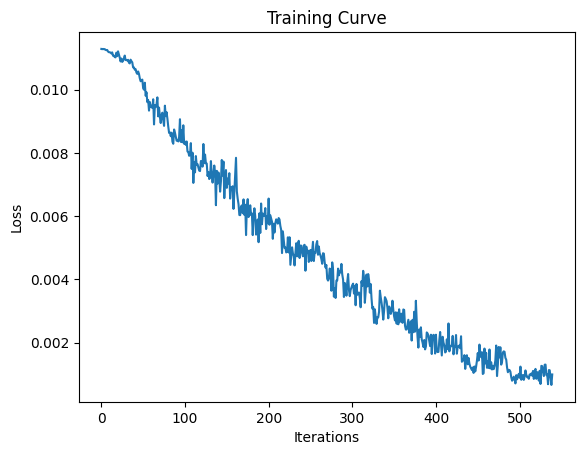

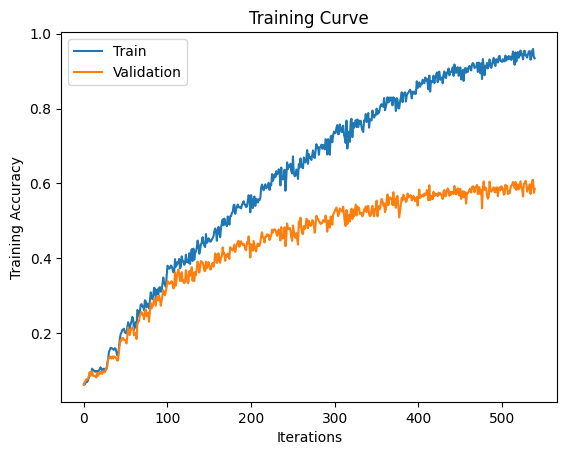

Final Training Accuracy: 0.9341500765696784
Final Validation Accuracy: 0.5856573705179283


In [37]:
use_cuda = True

model = AlexNet4('Primary')

if use_cuda and torch.cuda.is_available():
  model.cuda()
  print('CUDA is available!  Training on GPU ...')
  train(model, train_dataset_new, valid_dataset_new, batch_size=256, learning_rate = 0.01, num_epochs=10)
else:
  print('CUDA is not available.  Training on CPU ...')
  train(model, train_dataset_new, valid_dataset_new, batch_size=256, learning_rate = 0.01, num_epochs=10)

In [38]:
model = AlexNet4('Primary')
model_path = 'D:\AlexNet Type1 Balanced Features-20230721T150532Z-001\model_AlexNet4_bs256_lr0.01_epoch9'  # Update with your model's path
model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))

<All keys matched successfully>

CUDA is not available.  Training on CPU ...
epoch:  0 , iter:  0
epoch:  0 , iter:  1
epoch:  0 , iter:  2
epoch:  0 , iter:  3
epoch:  0 , iter:  4
epoch:  0 , iter:  5
epoch:  0 , iter:  6
epoch:  0 , iter:  7
epoch:  0 , iter:  8
epoch:  0 , iter:  9
epoch:  0 , iter:  10
epoch:  0 , iter:  11
epoch:  0 , iter:  12
epoch:  0 , iter:  13
epoch:  0 , iter:  14
epoch:  0 , iter:  15
epoch:  0 , iter:  16
epoch:  0 , iter:  17
epoch:  0 , iter:  18
epoch:  0 , iter:  19
epoch:  0 , iter:  20
epoch:  0 , iter:  21
epoch:  0 , iter:  22
epoch:  0 , iter:  23
epoch:  0 , iter:  24
epoch:  0 , iter:  25
epoch:  0 , iter:  26
epoch:  0 , iter:  27
epoch:  0 , iter:  28
epoch:  0 , iter:  29
epoch:  0 , iter:  30
epoch:  0 , iter:  31
epoch:  0 , iter:  32
epoch:  0 , iter:  33
epoch:  0 , iter:  34
epoch:  0 , iter:  35
epoch:  0 , iter:  36
epoch:  0 , iter:  37
epoch:  0 , iter:  38
epoch:  0 , iter:  39
epoch:  0 , iter:  40
epoch:  0 , iter:  41
epoch:  0 , iter:  42
epoch:  0 , iter:  4

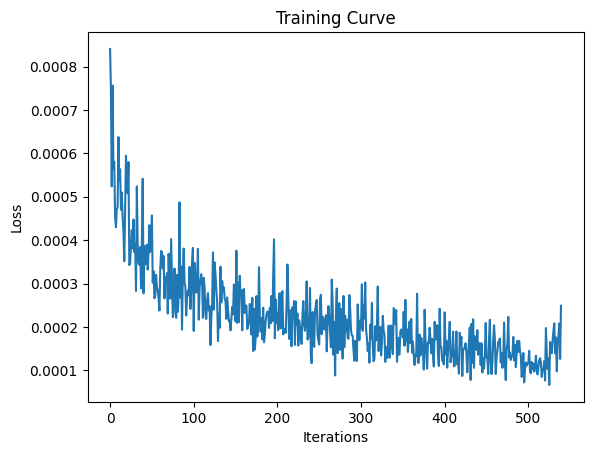

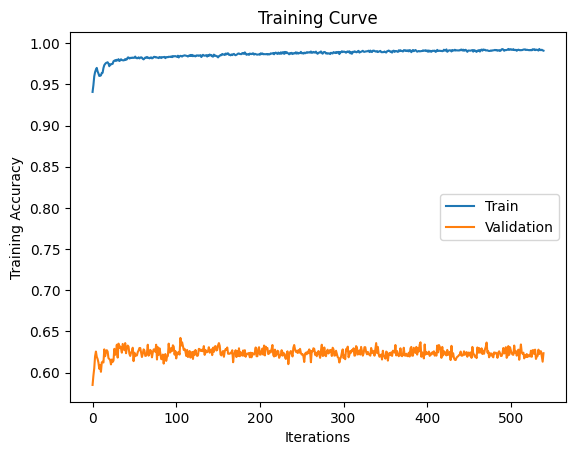

Final Training Accuracy: 0.9909574855976081
Final Validation Accuracy: 0.6235059760956175


In [39]:
use_cuda = True

if use_cuda and torch.cuda.is_available():
  model.cuda()
  print('CUDA is available!  Training on GPU ...')
  train(model, train_dataset_new, valid_dataset_new, batch_size=256, learning_rate = 0.001, num_epochs=10)
else:
  print('CUDA is not available.  Training on CPU ...')
  train(model, train_dataset_new, valid_dataset_new, batch_size=256, learning_rate = 0.001, num_epochs=10)

In [41]:
model = AlexNet4('Primary')
model_path = 'D:\AlexNet Type1 Balanced Features-20230721T150532Z-001\model_AlexNet4_bs256_lr0.001_epoch3'  # Update with your model's path
model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))

<All keys matched successfully>

In [42]:
get_accuracy(model, test_dataset_new, 256, train = False)

0.6115731115731116

In [72]:
model = AlexNet4('Primary')
model_path = 'D:\AlexNet Type1 Balanced Features-20230721T150532Z-001\model_AlexNet4_bs256_lr0.001_epoch1'  # Update with your model's path
model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))

<All keys matched successfully>

In [73]:
get_accuracy(model, test_dataset_new, 256, train = False)

0.6108801108801108

In [43]:
import torch.nn.functional as F

class AlexNet5(nn.Module):
    def __init__(self, typeClassifier):
        super(AlexNet5, self).__init__()
        self.name = "AlexNet5"
        if typeClassifier == 'Primary':
            numTypes = 18
        elif typeClassifier == 'Secondary':
            numTypes = 19

        self.conv1 = nn.Conv2d(256, 380, kernel_size=4, padding=1) # in_channels, out_channels, kernel_size
        self.conv2 = nn.Conv2d(380, 512, kernel_size=4, padding=1) # in_channels, out_channels, kernel_size
        self.fc1 = nn.Linear(512 * 4 * 4, 1024)
        self.fc2 = nn.Linear(1024, numTypes)
        self.dropout = nn.Dropout(0.25)  # Add dropout for regularization

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(-1, 512 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


CUDA is not available.  Training on CPU ...
epoch:  0 , iter:  0
epoch:  0 , iter:  1
epoch:  0 , iter:  2
epoch:  0 , iter:  3
epoch:  0 , iter:  4
epoch:  0 , iter:  5
epoch:  0 , iter:  6
epoch:  0 , iter:  7
epoch:  0 , iter:  8
epoch:  0 , iter:  9
epoch:  0 , iter:  10
epoch:  0 , iter:  11
epoch:  0 , iter:  12
epoch:  0 , iter:  13
epoch:  0 , iter:  14
epoch:  0 , iter:  15
epoch:  0 , iter:  16
epoch:  0 , iter:  17
epoch:  0 , iter:  18
epoch:  0 , iter:  19
epoch:  0 , iter:  20
epoch:  0 , iter:  21
epoch:  0 , iter:  22
epoch:  0 , iter:  23
epoch:  0 , iter:  24
epoch:  0 , iter:  25
epoch:  0 , iter:  26
epoch:  0 , iter:  27
epoch:  0 , iter:  28
epoch:  0 , iter:  29
epoch:  0 , iter:  30
epoch:  0 , iter:  31
epoch:  0 , iter:  32
epoch:  0 , iter:  33
epoch:  0 , iter:  34
epoch:  0 , iter:  35
epoch:  0 , iter:  36
epoch:  0 , iter:  37
epoch:  0 , iter:  38
epoch:  0 , iter:  39
epoch:  0 , iter:  40
epoch:  0 , iter:  41
epoch:  0 , iter:  42
epoch:  0 , iter:  4

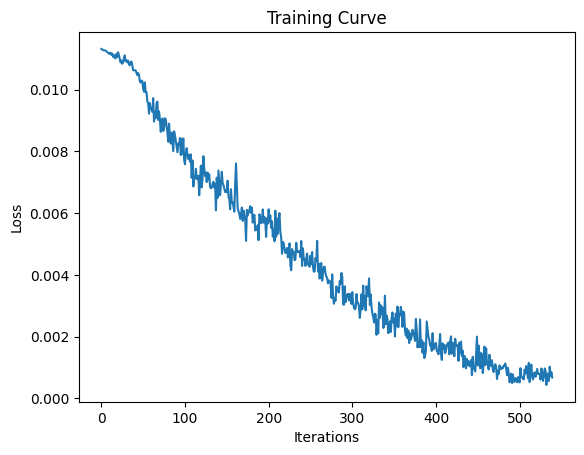

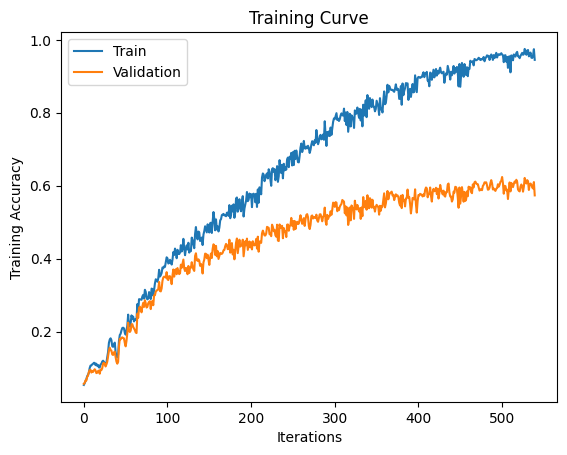

Final Training Accuracy: 0.9450156785531977
Final Validation Accuracy: 0.5733731739707836


In [44]:
use_cuda = True

model = AlexNet5('Primary')

if use_cuda and torch.cuda.is_available():
  model.cuda()
  print('CUDA is available!  Training on GPU ...')
  train(model, train_dataset_new, valid_dataset_new, batch_size=256, learning_rate = 0.01, num_epochs=10)
else:
  print('CUDA is not available.  Training on CPU ...')
  train(model, train_dataset_new, valid_dataset_new, batch_size=256, learning_rate = 0.01, num_epochs=10)

In [47]:
import torch.nn.functional as F

class AlexNet6(nn.Module):
    def __init__(self, typeClassifier):
        super(AlexNet6, self).__init__()
        self.name = "AlexNet6"
        if typeClassifier == 'Primary':
            numTypes = 18
        elif typeClassifier == 'Secondary':
            numTypes = 19

        self.conv1 = nn.Conv2d(256, 380, kernel_size=4, padding=1) # in_channels, out_channels, kernel_size
        self.conv2 = nn.Conv2d(380, 512, kernel_size=4, padding=1) # in_channels, out_channels, kernel_size
        self.fc1 = nn.Linear(512 * 4 * 4, 1024)
        self.fc2 = nn.Linear(1024, numTypes)
        self.dropout = nn.Dropout(0.75)  # Add dropout for regularization

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(-1, 512 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


CUDA is not available.  Training on CPU ...
epoch:  0 , iter:  0
epoch:  0 , iter:  1
epoch:  0 , iter:  2
epoch:  0 , iter:  3
epoch:  0 , iter:  4
epoch:  0 , iter:  5
epoch:  0 , iter:  6
epoch:  0 , iter:  7
epoch:  0 , iter:  8
epoch:  0 , iter:  9
epoch:  0 , iter:  10
epoch:  0 , iter:  11
epoch:  0 , iter:  12
epoch:  0 , iter:  13
epoch:  0 , iter:  14
epoch:  0 , iter:  15
epoch:  0 , iter:  16
epoch:  0 , iter:  17
epoch:  0 , iter:  18
epoch:  0 , iter:  19
epoch:  0 , iter:  20
epoch:  0 , iter:  21
epoch:  0 , iter:  22
epoch:  0 , iter:  23
epoch:  0 , iter:  24
epoch:  0 , iter:  25
epoch:  0 , iter:  26
epoch:  0 , iter:  27
epoch:  0 , iter:  28
epoch:  0 , iter:  29
epoch:  0 , iter:  30
epoch:  0 , iter:  31
epoch:  0 , iter:  32
epoch:  0 , iter:  33
epoch:  0 , iter:  34
epoch:  0 , iter:  35
epoch:  0 , iter:  36
epoch:  0 , iter:  37
epoch:  0 , iter:  38
epoch:  0 , iter:  39
epoch:  0 , iter:  40
epoch:  0 , iter:  41
epoch:  0 , iter:  42
epoch:  0 , iter:  4

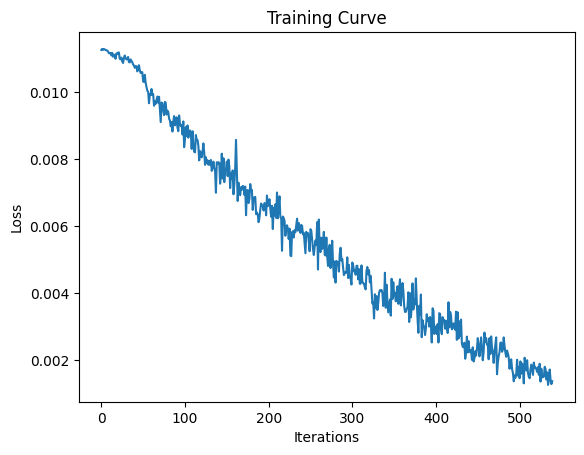

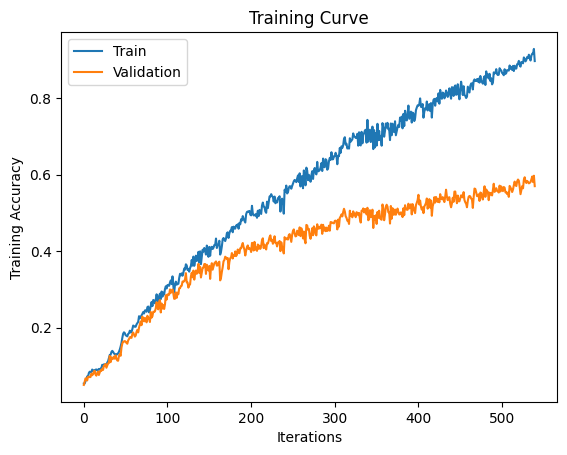

Final Training Accuracy: 0.8963027783854737
Final Validation Accuracy: 0.5697211155378487


In [48]:
use_cuda = True

model = AlexNet6('Primary')

if use_cuda and torch.cuda.is_available():
  model.cuda()
  print('CUDA is available!  Training on GPU ...')
  train(model, train_dataset_new, valid_dataset_new, batch_size=256, learning_rate = 0.01, num_epochs=10)
else:
  print('CUDA is not available.  Training on CPU ...')
  train(model, train_dataset_new, valid_dataset_new, batch_size=256, learning_rate = 0.01, num_epochs=10)

In [51]:
import torch.nn.functional as F

class AlexNet7(nn.Module):
    def __init__(self, typeClassifier):
        super(AlexNet7, self).__init__()
        self.name = "AlexNet7"
        if typeClassifier == 'Primary':
            numTypes = 18
        elif typeClassifier == 'Secondary':
            numTypes = 19
        self.fc1 = nn.Linear(256 * 6 * 6, 1024)
        self.fc2 = nn.Linear(1024, numTypes)

    def forward(self, x):
        
        x = x.view(-1, 256 * 6 * 6)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


CUDA is not available.  Training on CPU ...
epoch:  0 , iter:  0
epoch:  0 , iter:  1
epoch:  0 , iter:  2
epoch:  0 , iter:  3
epoch:  0 , iter:  4
epoch:  0 , iter:  5
epoch:  0 , iter:  6
epoch:  0 , iter:  7
epoch:  0 , iter:  8
epoch:  0 , iter:  9
epoch:  0 , iter:  10
epoch:  0 , iter:  11
epoch:  0 , iter:  12
epoch:  0 , iter:  13
epoch:  0 , iter:  14
epoch:  0 , iter:  15
epoch:  0 , iter:  16
epoch:  0 , iter:  17
epoch:  0 , iter:  18
epoch:  0 , iter:  19
epoch:  0 , iter:  20
epoch:  0 , iter:  21
epoch:  0 , iter:  22
epoch:  0 , iter:  23
epoch:  0 , iter:  24
epoch:  0 , iter:  25
epoch:  0 , iter:  26
epoch:  0 , iter:  27
epoch:  0 , iter:  28
epoch:  0 , iter:  29
epoch:  0 , iter:  30
epoch:  0 , iter:  31
epoch:  0 , iter:  32
epoch:  0 , iter:  33
epoch:  0 , iter:  34
epoch:  0 , iter:  35
epoch:  0 , iter:  36
epoch:  0 , iter:  37
epoch:  0 , iter:  38
epoch:  0 , iter:  39
epoch:  0 , iter:  40
epoch:  0 , iter:  41
epoch:  0 , iter:  42
epoch:  0 , iter:  4

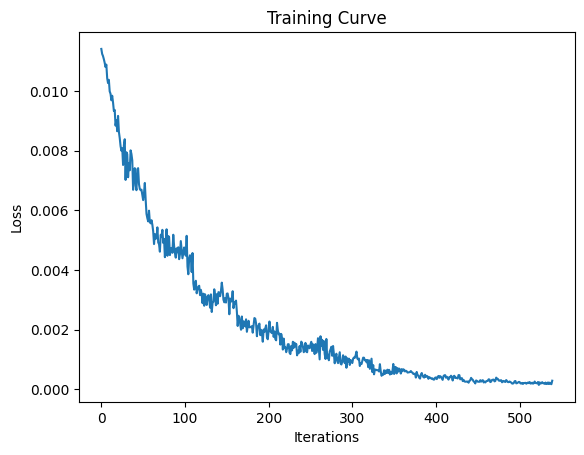

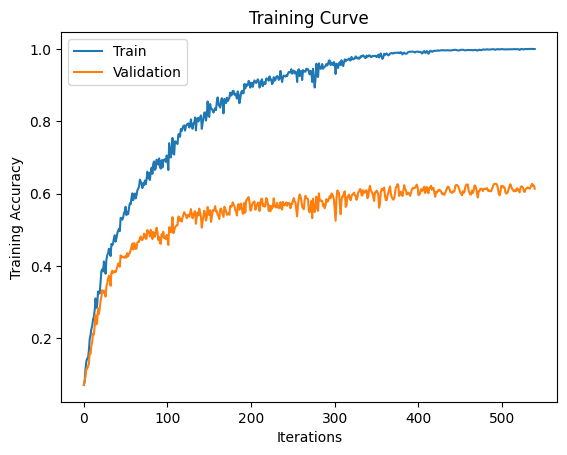

Final Training Accuracy: 0.9993436884707941
Final Validation Accuracy: 0.6135458167330677


In [52]:
use_cuda = True

model = AlexNet7('Primary')

if use_cuda and torch.cuda.is_available():
  model.cuda()
  print('CUDA is available!  Training on GPU ...')
  train(model, train_dataset_new, valid_dataset_new, batch_size=256, learning_rate = 0.01, num_epochs=10)
else:
  print('CUDA is not available.  Training on CPU ...')
  train(model, train_dataset_new, valid_dataset_new, batch_size=256, learning_rate = 0.01, num_epochs=10)

In [55]:
get_accuracy(model, test_dataset_new, 256)

0.6008316008316008

In [57]:
class AlexNet8(nn.Module):
    def init(self, typeClassifier):
        super(AlexNet8, self).init()
        self.name = "AlexNet8"
        if typeClassifier == 'Primary':
            numTypes = 18
        elif typeClassifier == 'Secondary':
            numTypes = 19

        self.conv1 = nn.Conv2d(256, 380, kernel_size=2) #in_channels, out_chanels, kernel_size
        self.conv2 = nn.Conv2d(380, 512, kernel_size=2) #in_channels, out_chanels, kernel_size
        self.fc1 = nn.Linear(512 * 4 * 4, 1024) # Adjust the input size for the fully connected layer
        self.fc2 = nn.Linear(1024, numTypes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(-1, 512 * 4 * 4) # Adjust the input size for the fully connected layer
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

CUDA is not available.  Training on CPU ...
epoch:  0 , iter:  0
epoch:  0 , iter:  1
epoch:  0 , iter:  2
epoch:  0 , iter:  3
epoch:  0 , iter:  4
epoch:  0 , iter:  5
epoch:  0 , iter:  6
epoch:  0 , iter:  7
epoch:  0 , iter:  8
epoch:  0 , iter:  9
epoch:  0 , iter:  10
epoch:  0 , iter:  11
epoch:  0 , iter:  12
epoch:  0 , iter:  13
epoch:  0 , iter:  14
epoch:  0 , iter:  15
epoch:  0 , iter:  16
epoch:  0 , iter:  17
epoch:  0 , iter:  18
epoch:  0 , iter:  19
epoch:  0 , iter:  20
epoch:  0 , iter:  21
epoch:  0 , iter:  22
epoch:  0 , iter:  23
epoch:  0 , iter:  24
epoch:  0 , iter:  25
epoch:  0 , iter:  26
epoch:  0 , iter:  27
epoch:  0 , iter:  28
epoch:  0 , iter:  29
epoch:  0 , iter:  30
epoch:  0 , iter:  31
epoch:  0 , iter:  32
epoch:  0 , iter:  33
epoch:  0 , iter:  34
epoch:  0 , iter:  35
epoch:  0 , iter:  36
epoch:  0 , iter:  37
epoch:  0 , iter:  38
epoch:  0 , iter:  39
epoch:  0 , iter:  40
epoch:  0 , iter:  41
epoch:  0 , iter:  42
epoch:  0 , iter:  4

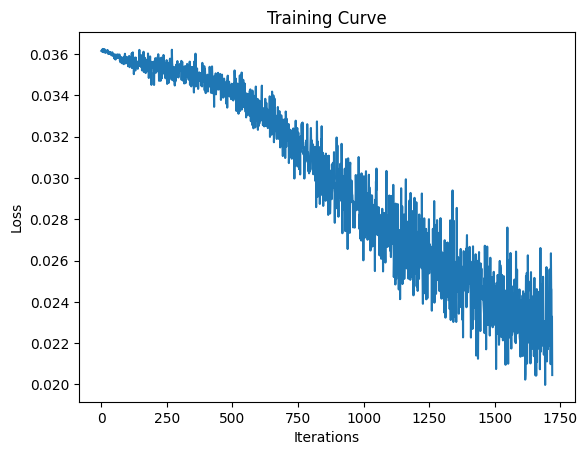

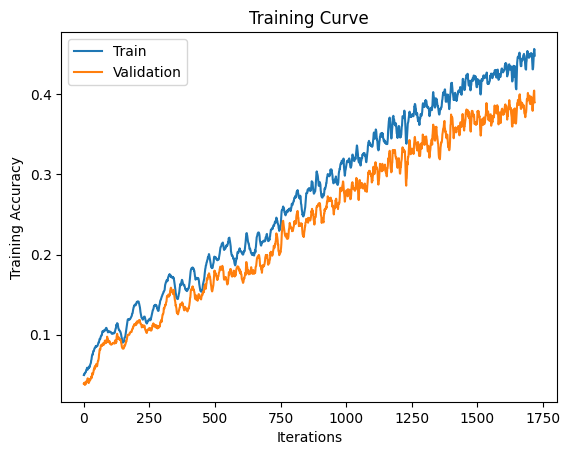

Final Training Accuracy: 0.4479690804346241
Final Validation Accuracy: 0.3897742363877822


In [62]:
use_cuda = True

model = AlexNet('Primary')

if use_cuda and torch.cuda.is_available():
  model.cuda()
  print('CUDA is available!  Training on GPU ...')
  train(model, train_dataset_new, valid_dataset_new, batch_size = 80, learning_rate = 0.0005, num_epochs=10)
else:
  print('CUDA is not available.  Training on CPU ...')
  train(model, train_dataset_new, valid_dataset_new, batch_size = 80, learning_rate = 0.0005, num_epochs=10)

In [63]:
model = AlexNet('Primary')
model_path = 'D:\AlexNet Type1 Balanced Features-20230721T150532Z-001\model_AlexNet_bs80_lr0.0005_epoch9'  # Update with your model's path
model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))

<All keys matched successfully>

CUDA is not available.  Training on CPU ...
epoch:  0 , iter:  0
epoch:  0 , iter:  1
epoch:  0 , iter:  2
epoch:  0 , iter:  3
epoch:  0 , iter:  4
epoch:  0 , iter:  5
epoch:  0 , iter:  6
epoch:  0 , iter:  7
epoch:  0 , iter:  8
epoch:  0 , iter:  9
epoch:  0 , iter:  10
epoch:  0 , iter:  11
epoch:  0 , iter:  12
epoch:  0 , iter:  13
epoch:  0 , iter:  14
epoch:  0 , iter:  15
epoch:  0 , iter:  16
epoch:  0 , iter:  17
epoch:  0 , iter:  18
epoch:  0 , iter:  19
epoch:  0 , iter:  20
epoch:  0 , iter:  21
epoch:  0 , iter:  22
epoch:  0 , iter:  23
epoch:  0 , iter:  24
epoch:  0 , iter:  25
epoch:  0 , iter:  26
epoch:  0 , iter:  27
epoch:  0 , iter:  28
epoch:  0 , iter:  29
epoch:  0 , iter:  30
epoch:  0 , iter:  31
epoch:  0 , iter:  32
epoch:  0 , iter:  33
epoch:  0 , iter:  34
epoch:  0 , iter:  35
epoch:  0 , iter:  36
epoch:  0 , iter:  37
epoch:  0 , iter:  38
epoch:  0 , iter:  39
epoch:  0 , iter:  40
epoch:  0 , iter:  41
epoch:  0 , iter:  42
epoch:  0 , iter:  4

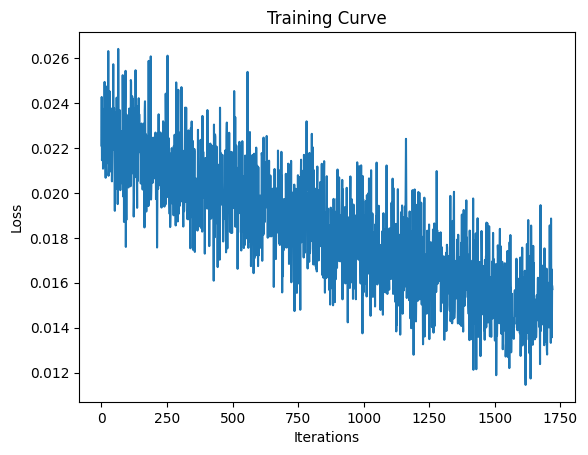

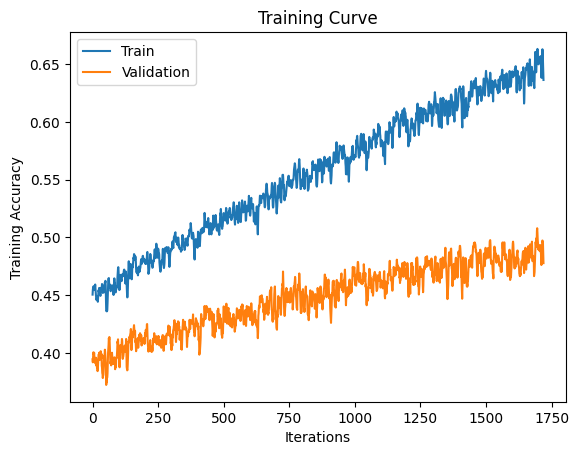

Final Training Accuracy: 0.636476336323197
Final Validation Accuracy: 0.47775564409030546


In [64]:
use_cuda = True

if use_cuda and torch.cuda.is_available():
  model.cuda()
  print('CUDA is available!  Training on GPU ...')
  train(model, train_dataset_new, valid_dataset_new, batch_size = 80, learning_rate = 0.0005, num_epochs=10)
else:
  print('CUDA is not available.  Training on CPU ...')
  train(model, train_dataset_new, valid_dataset_new, batch_size = 80, learning_rate = 0.0005, num_epochs=10)

In [65]:
import torch.nn.functional as F

class AlexNet4_no_drop(nn.Module):
    def __init__(self, typeClassifier):
        super(AlexNet4_no_drop, self).__init__()
        self.name = "AlexNet4_no_drop"
        if typeClassifier == 'Primary':
            numTypes = 18
        elif typeClassifier == 'Secondary':
            numTypes = 19

        self.conv1 = nn.Conv2d(256, 380, kernel_size=4, padding=1) # in_channels, out_channels, kernel_size
        self.conv2 = nn.Conv2d(380, 512, kernel_size=4, padding=1) # in_channels, out_channels, kernel_size
        self.fc1 = nn.Linear(512 * 4 * 4, 1024)
        self.fc2 = nn.Linear(1024, numTypes)
        self.dropout = nn.Dropout(0.5)  # Add dropout for regularization

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(-1, 512 * 4 * 4)
        x = F.relu(self.fc1(x))
        #x = self.dropout(x)
        x = self.fc2(x)
        return x


CUDA is not available.  Training on CPU ...
epoch:  0 , iter:  0
epoch:  0 , iter:  1
epoch:  0 , iter:  2
epoch:  0 , iter:  3
epoch:  0 , iter:  4
epoch:  0 , iter:  5
epoch:  0 , iter:  6
epoch:  0 , iter:  7
epoch:  0 , iter:  8
epoch:  0 , iter:  9
epoch:  0 , iter:  10
epoch:  0 , iter:  11
epoch:  0 , iter:  12
epoch:  0 , iter:  13
epoch:  0 , iter:  14
epoch:  0 , iter:  15
epoch:  0 , iter:  16
epoch:  0 , iter:  17
epoch:  0 , iter:  18
epoch:  0 , iter:  19
epoch:  0 , iter:  20
epoch:  0 , iter:  21
epoch:  0 , iter:  22
epoch:  0 , iter:  23
epoch:  0 , iter:  24
epoch:  0 , iter:  25
epoch:  0 , iter:  26
epoch:  0 , iter:  27
epoch:  0 , iter:  28
epoch:  0 , iter:  29
epoch:  0 , iter:  30
epoch:  0 , iter:  31
epoch:  0 , iter:  32
epoch:  0 , iter:  33
epoch:  0 , iter:  34
epoch:  0 , iter:  35
epoch:  0 , iter:  36
epoch:  0 , iter:  37
epoch:  0 , iter:  38
epoch:  0 , iter:  39
epoch:  0 , iter:  40
epoch:  0 , iter:  41
epoch:  0 , iter:  42
epoch:  0 , iter:  4

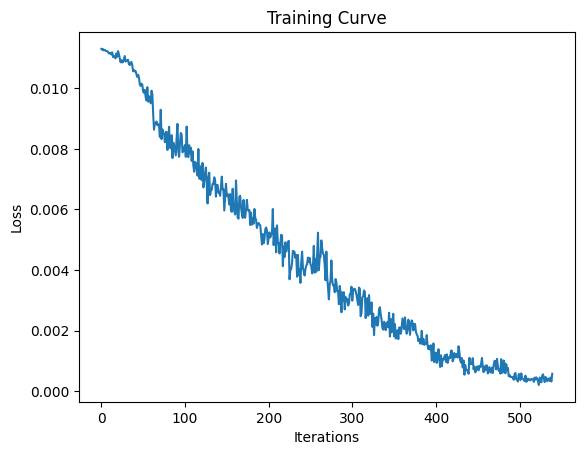

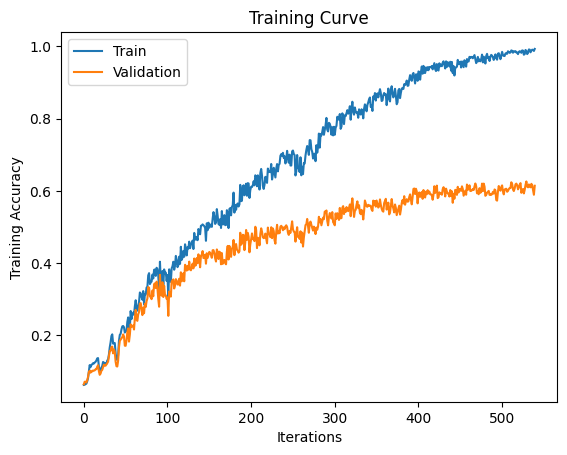

Final Training Accuracy: 0.993145190694961
Final Validation Accuracy: 0.6142098273572377


In [66]:
use_cuda = True

model = AlexNet4_no_drop('Primary')

if use_cuda and torch.cuda.is_available():
  model.cuda()
  print('CUDA is available!  Training on GPU ...')
  train(model, train_dataset_new, valid_dataset_new, batch_size=256, learning_rate = 0.01, num_epochs=10)
else:
  print('CUDA is not available.  Training on CPU ...')
  train(model, train_dataset_new, valid_dataset_new, batch_size=256, learning_rate = 0.01, num_epochs=10)

In [67]:
get_accuracy(model, test_dataset_new, 256)

0.6046431046431047

In [9]:
path_train = 'D:\AlexNet Type2 Balanced Features-20230803T200927Z-001\AlexNet Type2 Balanced Features\Train'
path_val = 'D:\AlexNet Type2 Balanced Features-20230803T200927Z-001\AlexNet Type2 Balanced Features\Val'
path_test = 'D:\AlexNet Type2 Balanced Features-20230803T200927Z-001\AlexNet Type2 Balanced Features\Test'

train_dataset_new = torchvision.datasets.DatasetFolder(path_train, loader=torch.load, extensions=('.tensor'))
valid_dataset_new = torchvision.datasets.DatasetFolder(path_val, loader=torch.load, extensions=('.tensor'))
test_dataset_new = torchvision.datasets.DatasetFolder(path_test, loader=torch.load, extensions=('.tensor'))


In [8]:
class AlexNet(nn.Module):
    def __init__(self, typeClassifier):
        super(AlexNet, self).__init__()
        self.name = "AlexNet"
        if typeClassifier == 'Primary':
            numTypes = 18
        elif typeClassifier == 'Secondary':
            numTypes = 19

        self.conv1 = nn.Conv2d(256, 380, kernel_size=2) #in_channels, out_chanels, kernel_size
        self.conv2 = nn.Conv2d(380, 512, kernel_size=2) #in_channels, out_chanels, kernel_size
        self.fc1 = nn.Linear(512*4*4, 1024)
        self.fc2 = nn.Linear(1024, numTypes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(-1, 512*4*4)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

CUDA is not available.  Training on CPU ...
epoch:  0 , iter:  0
epoch:  0 , iter:  1
epoch:  0 , iter:  2
epoch:  0 , iter:  3
epoch:  0 , iter:  4
epoch:  0 , iter:  5
epoch:  0 , iter:  6
epoch:  0 , iter:  7
epoch:  0 , iter:  8
epoch:  0 , iter:  9
epoch:  0 , iter:  10
epoch:  0 , iter:  11
epoch:  0 , iter:  12
epoch:  0 , iter:  13
epoch:  0 , iter:  14
epoch:  0 , iter:  15
epoch:  0 , iter:  16
epoch:  0 , iter:  17
epoch:  0 , iter:  18
epoch:  0 , iter:  19
epoch:  0 , iter:  20
epoch:  0 , iter:  21
epoch:  0 , iter:  22
epoch:  0 , iter:  23
epoch:  0 , iter:  24
epoch:  0 , iter:  25
epoch:  0 , iter:  26
epoch:  0 , iter:  27
epoch:  0 , iter:  28
epoch:  0 , iter:  29
epoch:  0 , iter:  30
Epoch 1: Train acc: 0.12068741049342534 | Val acc: 0.09475150952159778
epoch:  1 , iter:  31
epoch:  1 , iter:  32
epoch:  1 , iter:  33
epoch:  1 , iter:  34
epoch:  1 , iter:  35
epoch:  1 , iter:  36
epoch:  1 , iter:  37
epoch:  1 , iter:  38
epoch:  1 , iter:  39
epoch:  1 , ite

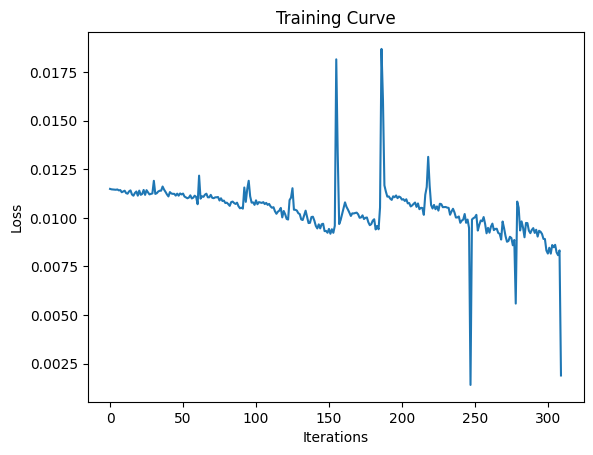

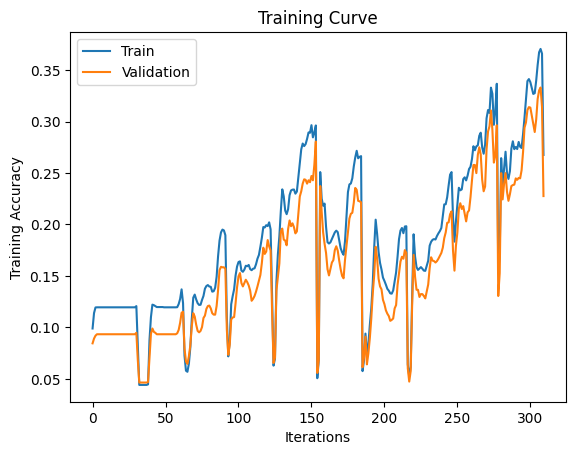

Final Training Accuracy: 0.2675432886342924
Final Validation Accuracy: 0.2275894101254064


In [10]:
use_cuda = True

model = AlexNet('Secondary')

if use_cuda and torch.cuda.is_available():
  model.cuda()
  print('CUDA is available!  Training on GPU ...')
  train(model, train_dataset_new, valid_dataset_new, batch_size=256, learning_rate = 0.01, num_epochs=10)
else:
  print('CUDA is not available.  Training on CPU ...')
  train(model, train_dataset_new, valid_dataset_new, batch_size=256, learning_rate = 0.01, num_epochs=10)

In [11]:
path_train = 'D:\AlexNet Type2 Balanced Features-20230803T200927Z-001\AlexNet Type2 Larger Features-20230804T030320Z-001\AlexNet Type2 Larger Features\Train'
path_val = 'D:\AlexNet Type2 Balanced Features-20230803T200927Z-001\AlexNet Type2 Larger Features-20230804T030320Z-001\AlexNet Type2 Larger Features\Val'
path_test = 'D:\AlexNet Type2 Balanced Features-20230803T200927Z-001\AlexNet Type2 Larger Features-20230804T030320Z-001\AlexNet Type2 Larger Features\Test'

train_dataset_new = torchvision.datasets.DatasetFolder(path_train, loader=torch.load, extensions=('.tensor'))
valid_dataset_new = torchvision.datasets.DatasetFolder(path_val, loader=torch.load, extensions=('.tensor'))
test_dataset_new = torchvision.datasets.DatasetFolder(path_test, loader=torch.load, extensions=('.tensor'))


CUDA is not available.  Training on CPU ...
epoch:  0 , iter:  0
epoch:  0 , iter:  1
epoch:  0 , iter:  2
epoch:  0 , iter:  3
epoch:  0 , iter:  4
epoch:  0 , iter:  5
epoch:  0 , iter:  6
epoch:  0 , iter:  7
epoch:  0 , iter:  8
epoch:  0 , iter:  9
epoch:  0 , iter:  10
epoch:  0 , iter:  11
epoch:  0 , iter:  12
epoch:  0 , iter:  13
epoch:  0 , iter:  14
epoch:  0 , iter:  15
epoch:  0 , iter:  16
epoch:  0 , iter:  17
epoch:  0 , iter:  18
epoch:  0 , iter:  19
epoch:  0 , iter:  20
epoch:  0 , iter:  21
epoch:  0 , iter:  22
epoch:  0 , iter:  23
epoch:  0 , iter:  24
epoch:  0 , iter:  25
epoch:  0 , iter:  26
epoch:  0 , iter:  27
epoch:  0 , iter:  28
Epoch 1: Train acc: 0.4823432794963044 | Val acc: 0.4140061791967044
epoch:  1 , iter:  29
epoch:  1 , iter:  30
epoch:  1 , iter:  31
epoch:  1 , iter:  32
epoch:  1 , iter:  33
epoch:  1 , iter:  34
epoch:  1 , iter:  35
epoch:  1 , iter:  36
epoch:  1 , iter:  37
epoch:  1 , iter:  38
epoch:  1 , iter:  39
epoch:  1 , iter:

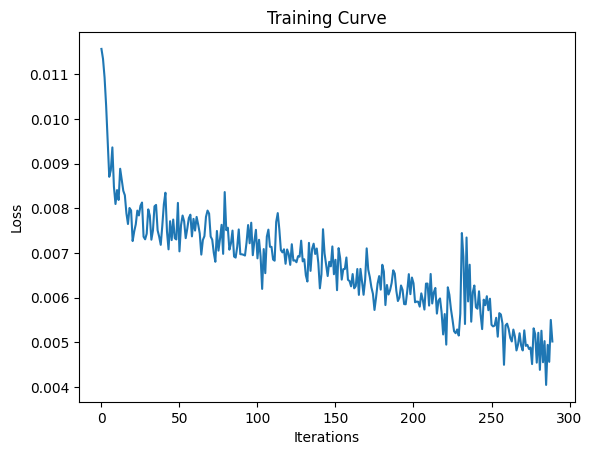

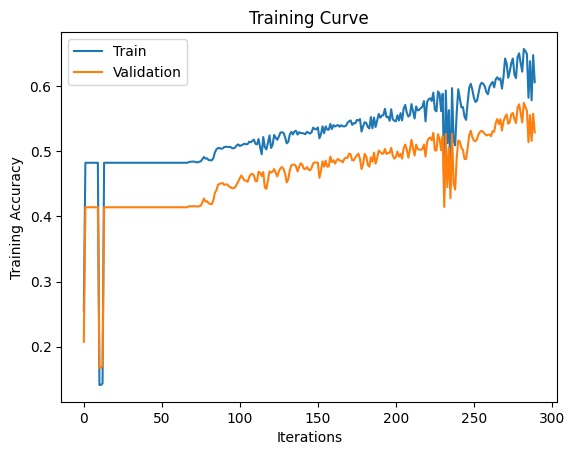

Final Training Accuracy: 0.6060771968245278
Final Validation Accuracy: 0.5288362512873327


In [12]:
use_cuda = True

model = AlexNet('Secondary')

if use_cuda and torch.cuda.is_available():
  model.cuda()
  print('CUDA is available!  Training on GPU ...')
  train(model, train_dataset_new, valid_dataset_new, batch_size=256, learning_rate = 0.01, num_epochs=10)
else:
  print('CUDA is not available.  Training on CPU ...')
  train(model, train_dataset_new, valid_dataset_new, batch_size=256, learning_rate = 0.01, num_epochs=10)